In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
board_dict = {
    "a" : 1, "b" : 2, "c" : 3, "d" : 4, 
    "e" : 5, "f" : 6, "g" : 7, "h" : 8
}
depth_dict = {
    "zero" : 0, "one" : 1, "two" : 2, "three" : 3,
    "four" : 4, "five" : 5, "six" : 6, "seven" : 7,
    "eight" : 8, "nine" : 9, "ten" : 10, "eleven" : 11,
    "twelve" : 12, "thirteen" : 13, "fourteen" : 14, "fifteen" : 15,
    "sixteen" : 16, "draw" : 17
}
# f = lambda x: np.array([board_dict.get(x[0]), x[1], board_dict.get(x[2]), x[3], board_dict.get(x[4]), x[5], depth_dict.get(x[6])])

In [3]:
# data = np.loadtxt('train.data', delimiter=',', dtype='str')
# data = np.array([f(row) for row in data], dtype=np.float32)

data = pd.read_csv('train.data', names=['wking_file', 'wking_rank', 'wrook_file', 'wrook_rank', 'bking_file', 'bking_rank', 'depth'])

data['wking_file'] = data['wking_file'].apply(lambda x : board_dict.get(x))
data['wrook_file'] = data['wrook_file'].apply(lambda x : board_dict.get(x))
data['bking_file'] = data['bking_file'].apply(lambda x : board_dict.get(x))
data['depth'] = data['depth'].apply(lambda x : depth_dict.get(x))

data.head()

,wking_file,wking_rank,wrook_file,wrook_rank,bking_file,bking_rank,depth
0,4,1,4,5,6,5,14
1,3,2,7,7,5,8,10
2,2,1,6,7,8,7,13
3,3,2,4,1,7,5,13
4,4,1,4,7,7,2,12


<AxesSubplot:xlabel='depth', ylabel='count'>

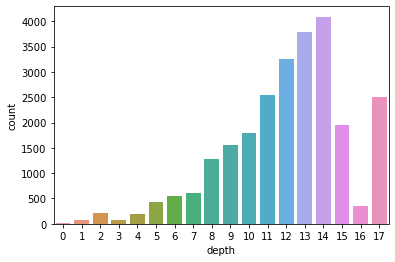

In [4]:
sns.countplot(x = 'depth', data=data)

In [5]:
X = data.iloc[:, 0:-1]
y = data.iloc[:, -1]

In [6]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=1)

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [8]:
def get_class_distribution(obj):
    count_dict = {
        "0":0,
        "1": 0,
        "2": 0,
        "3": 0,
        "4": 0,
        "5": 0,
        "6": 0,
        "7": 0,
        "8": 0,
        "9": 0,
        "10": 0,
        "11": 0,
        "12": 0,
        "13": 0,
        "14": 0,
        "15": 0,
        "16": 0,
        "draw": 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['0'] += 1
        elif i == 1: 
            count_dict['1'] += 1
        elif i == 2: 
            count_dict['2'] += 1
        elif i == 3: 
            count_dict['3'] += 1
        elif i == 4: 
            count_dict['4'] += 1  
        elif i == 5: 
            count_dict['5'] += 1
        elif i == 6: 
            count_dict['6'] += 1
        elif i == 7: 
            count_dict['7'] += 1
        elif i == 8: 
            count_dict['8'] += 1 
        elif i == 9: 
            count_dict['9'] += 1
        elif i == 10: 
            count_dict['10'] += 1
        elif i == 11: 
            count_dict['11'] += 1
        elif i == 12: 
            count_dict['12'] += 1 
        elif i == 13: 
            count_dict['13'] += 1 
        elif i == 14: 
            count_dict['14'] += 1
        elif i == 15: 
            count_dict['15'] += 1
        elif i == 16: 
            count_dict['16'] += 1
        elif i == 17: 
            count_dict['draw'] += 1              
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

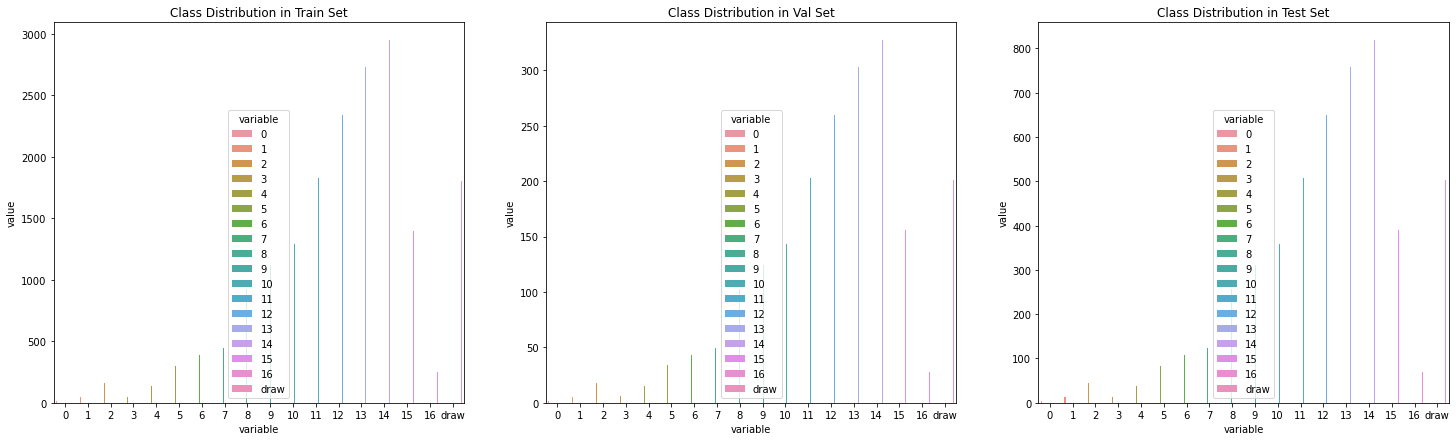

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [10]:
class ChessDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X) 

In [11]:
train_dataset = ChessDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ChessDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ChessDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [12]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)

In [13]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.0556, 0.0204, 0.0063, 0.0200, 0.0075, 0.0033, 0.0026, 0.0022, 0.0011,
        0.0009, 0.0008, 0.0005, 0.0004, 0.0004, 0.0003, 0.0007, 0.0039, 0.0006])


In [14]:
class_weights_all = class_weights[target_list]

In [15]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [16]:
EPOCHS = 200
BATCH_SIZE = 8
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 18

In [17]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [18]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.relu_1 = nn.ReLU()
        
        self.layer_2 = nn.Linear(512, 384)
        self.relu_2 = nn.ReLU()
        
        self.layer_3 = nn.Linear(384, 256)
        self.relu_3 = nn.ReLU()
        
        self.layer_4 = nn.Linear(256, 128)
        self.relu_4 = nn.ReLU()
        
        self.layer_5 = nn.Linear(128, 64)
        self.relu_5 = nn.ReLU()
        
        self.layer_6 = nn.Linear(64, 32)
        self.relu_6 = nn.ReLU()
        
        self.layer_out = nn.Linear(32, num_class) 
        
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(384)
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.batchnorm4 = nn.BatchNorm1d(128)
        self.batchnorm5 = nn.BatchNorm1d(64)
        self.batchnorm6 = nn.BatchNorm1d(32)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu_1(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu_2(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu_3(x)
        
        x = self.layer_4(x)
        x = self.batchnorm4(x)
        x = self.relu_4(x)
        
        x = self.layer_5(x)
        x = self.batchnorm5(x)
        x = self.relu_5(x)
        
        x = self.layer_6(x)
        x = self.batchnorm6(x)
        x = self.relu_6(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [20]:
model = torch.load(r'C:\Users\diasa\Machine-Learning\King-Rook_vs_King\model_scripted.pt')

In [21]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=6, out_features=512, bias=True)
  (relu_1): ReLU()
  (layer_2): Linear(in_features=512, out_features=384, bias=True)
  (relu_2): ReLU()
  (layer_3): Linear(in_features=384, out_features=256, bias=True)
  (relu_3): ReLU()
  (layer_4): Linear(in_features=256, out_features=128, bias=True)
  (relu_4): ReLU()
  (layer_5): Linear(in_features=128, out_features=64, bias=True)
  (relu_5): ReLU()
  (layer_6): Linear(in_features=64, out_features=32, bias=True)
  (relu_6): ReLU()
  (layer_out): Linear(in_features=32, out_features=18, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True

In [22]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [23]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [24]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0

    model.train()

    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

     # VALIDATION    
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
        

Begin training.


Epoch 001: | Train Loss: 1.72419 | Val Loss: 3.13544 | Train Acc: 18.693| Val Acc: 3.614
Epoch 002: | Train Loss: 1.46418 | Val Loss: 2.83959 | Train Acc: 22.409| Val Acc: 5.743
Epoch 003: | Train Loss: 1.37537 | Val Loss: 2.76362 | Train Acc: 24.223| Val Acc: 5.149
Epoch 004: | Train Loss: 1.30393 | Val Loss: 2.59053 | Train Acc: 25.491| Val Acc: 7.426
Epoch 005: | Train Loss: 1.26110 | Val Loss: 2.62172 | Train Acc: 26.484| Val Acc: 8.218
Epoch 006: | Train Loss: 1.24814 | Val Loss: 2.55874 | Train Acc: 27.630| Val Acc: 8.267
Epoch 007: | Train Loss: 1.22833 | Val Loss: 2.50549 | Train Acc: 27.444| Val Acc: 8.960
Epoch 008: | Train Loss: 1.18963 | Val Loss: 2.47114 | Train Acc: 28.939| Val Acc: 10.297
Epoch 009: | Train Loss: 1.13009 | Val Loss: 2.60320 | Train Acc: 29.293| Val Acc: 9.604
Epoch 010: | Train Loss: 1.14847 | Val Loss: 2.52705 | Train Acc: 29.832| Val Acc: 8.218
Epoch 011: | Train Loss: 1.10435 | Val Loss: 2.54831 | Train Acc: 30.536| Val Acc: 10.644
Epoch 012: | Train 

Epoch 093: | Train Loss: 0.77897 | Val Loss: 2.36603 | Train Acc: 41.332| Val Acc: 16.287
Epoch 094: | Train Loss: 0.77911 | Val Loss: 2.50803 | Train Acc: 41.075| Val Acc: 13.069
Epoch 095: | Train Loss: 0.76935 | Val Loss: 2.60503 | Train Acc: 41.137| Val Acc: 10.545
Epoch 096: | Train Loss: 0.76985 | Val Loss: 2.38141 | Train Acc: 41.846| Val Acc: 15.446
Epoch 097: | Train Loss: 0.77777 | Val Loss: 2.32801 | Train Acc: 41.595| Val Acc: 15.792
Epoch 098: | Train Loss: 0.81212 | Val Loss: 2.51620 | Train Acc: 40.150| Val Acc: 11.436
Epoch 099: | Train Loss: 0.74762 | Val Loss: 2.68172 | Train Acc: 41.549| Val Acc: 9.802
Epoch 100: | Train Loss: 0.80707 | Val Loss: 2.50422 | Train Acc: 40.915| Val Acc: 11.485
Epoch 101: | Train Loss: 0.76407 | Val Loss: 2.59632 | Train Acc: 40.832| Val Acc: 10.792
Epoch 102: | Train Loss: 0.78313 | Val Loss: 2.54009 | Train Acc: 41.106| Val Acc: 13.366
Epoch 103: | Train Loss: 0.77779 | Val Loss: 2.50883 | Train Acc: 41.534| Val Acc: 13.713
Epoch 104: 

KeyboardInterrupt: 

In [ ]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [ ]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))

plt.figure(figsize = (20, 20))
sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
print(classification_report(y_test, y_pred_list))

In [ ]:
torch.save(model.state_dict(), r'C:\Users\diasa\Machine-Learning\King-Rook_vs_King\model_scripted.pt')